In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

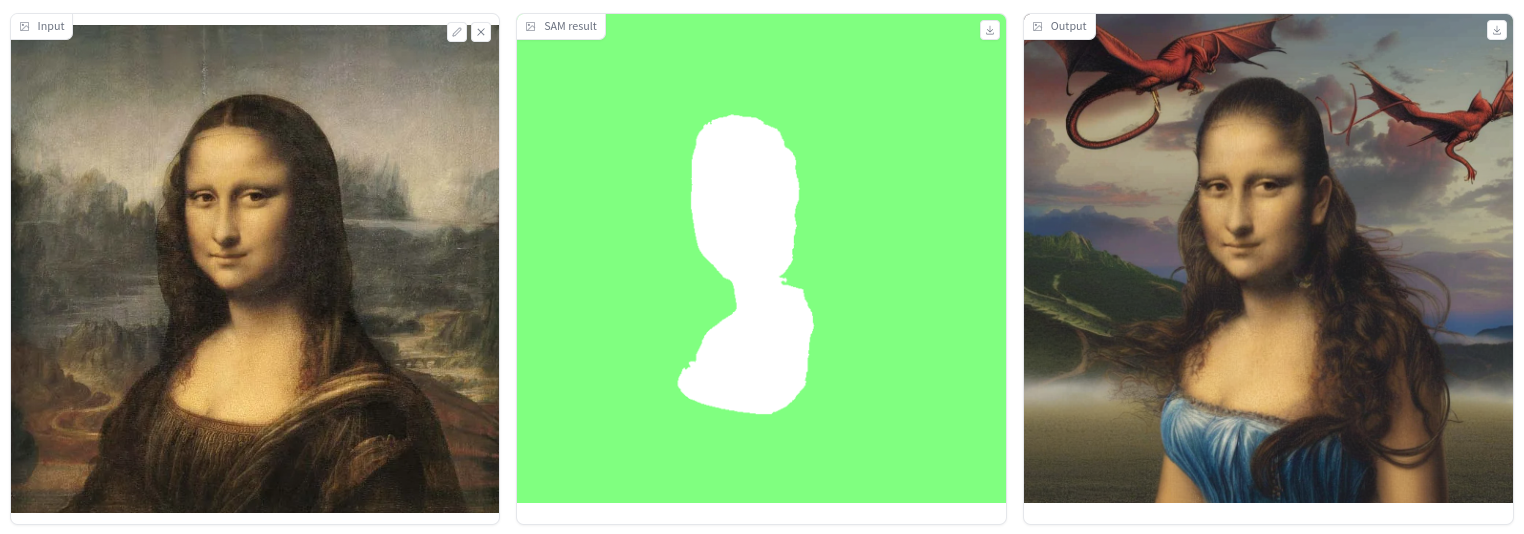

Let's start by importing what we need:

In [81]:
#Required Imports

import torch
import numpy as np
import requests
from PIL import Image
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import make_image_grid

In [82]:
# Check Metal (MPS) Availability
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device:", device)

Device: mps


## SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

This cell might take a couple of minutes to load.

In [83]:
# Load SAM Model & Processor
checkpoint = "facebook/sam-vit-base"
model = SamModel.from_pretrained(checkpoint).to(device)
processor = SamProcessor.from_pretrained(checkpoint)

### Get the mask

Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

In [84]:
#Transforms a binary mask into an RGBA image for visualization
# Color the area we will replace in green
# (this vector is [Red, Green, Blue, Alpha])

def mask_to_rgb(mask):
   bg_transparent = np.zeros(mask.shape + (4,), dtype=np.uint8)
   bg_transparent[mask == 1] = [0, 255, 0, 127]
   return bg_transparent


In [101]:
# Process Image for SAM Model
def get_processed_inputs(image, input_points):
    torch.mps.empty_cache()  # Free memory
    # Generate inputs using the processor
    inputs = processor(
        images=image, 
        input_points=input_points,
        return_tensors="pt"
    )

    # Convert all tensors to float32 explicitly
    inputs = {k: v.to(torch.float32).to(device) if v.dtype in [torch.float32, torch.float64] else v.to(device) for k, v in inputs.items()}

    # Run SAM model
    outputs = model(**inputs)

    # Extract and process outputs
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.float().cpu(),  # Ensure float32
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )

    # Select best mask & return in float32 numpy format
    best_mask = masks[0][0][outputs.iou_scores.argmax()]
    return best_mask.cpu().numpy().astype(np.float32)

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

<img src='car.png' width="200px"></img>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

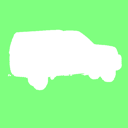

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

In [102]:
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))
input_points = [[[150, 170], [300, 250]]] # These are the coordinates of two points on the car
mask = get_processed_inputs(raw_image, input_points)
Image.fromarray(mask_to_rgb(mask)).resize((128, 128))

RuntimeError: MPS backend out of memory (MPS allocated: 27.18 GB, other allocations: 15.41 MB, max allowed: 27.20 GB). Tried to allocate 2.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code and run it (it might take a few minutes to run):

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

In [ ]:
# Load the AutoPipelineForInpainting pipeline from Hugging Face
pipeline_checkpoint = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"

pipeline = AutoPipelineForInpainting.from_pretrained(
    pipeline_checkpoint,
    torch_dtype=torch.float16)
    use_safetensors=True,
    variant="fp16"
pipeline.enable_attention_slicing(slice_size="auto")
pipeline.enable_vae_slicing()
pipeline = pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

In [78]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    torch.mps.empty_cache()  # Free memory

    mask_image = Image.fromarray(input_mask)

    rand_gen = torch.manual_seed(seed)

    # Run pipeline
    image = pipeline(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            image=raw_image,
            mask_image=mask_image,
            generator=rand_gen,
            guidance_scale=cfgs
    ).images[0] 
    torch.mps.empty_cache()  # Free memory after processing
    return image

Let's test our inpainting on the mask we have obtained earlier with SAM:

In [79]:
# Run Inpainting
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"
image = inpaint(raw_image, mask, prompt, negative_prompt)

  0%|          | 0/49 [00:00<?, ?it/s]

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/diffusers/image_processor.py:147: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


Let's have a look at what we have produced:

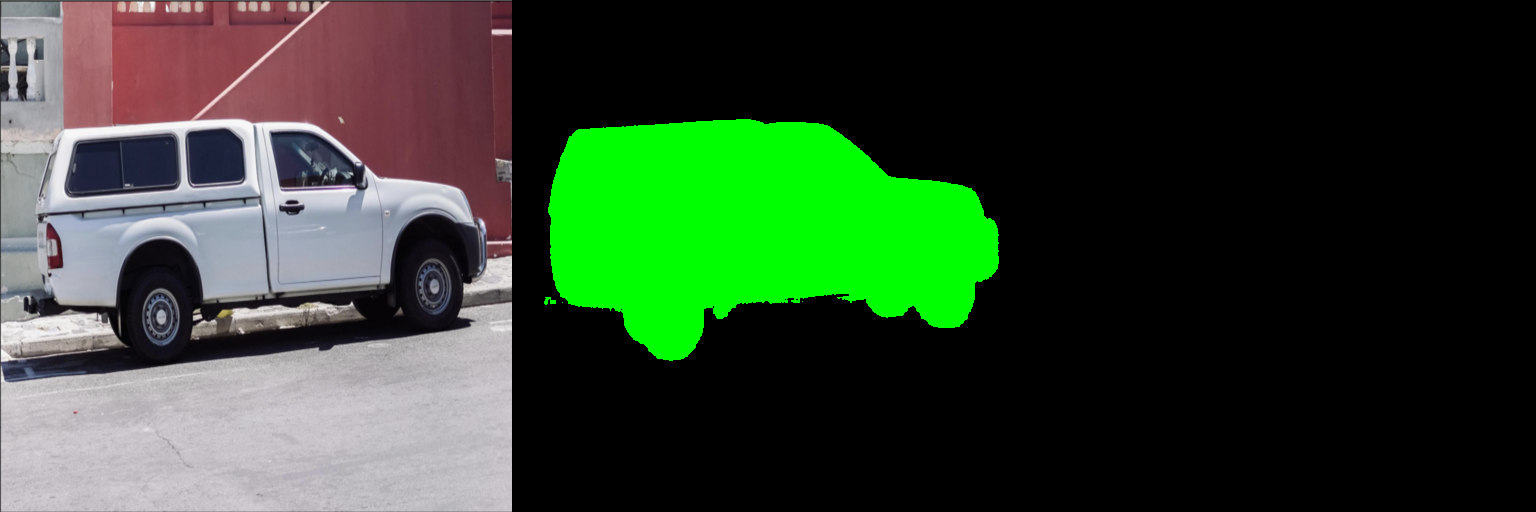

In [80]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:

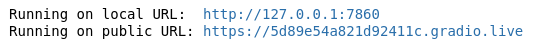

Click on the second link (the public URL), from there you will be able to use the app much more comfortably.

> NOTE: if for any reason you need to stop the app, click on the stop icon of the jupyter interface:   then **execute the next cell containing the code `my_app.close`**


In [ ]:
import app

In [ ]:
my_app = app.generate_app(get_processed_inputs, inpaint)

In [ ]:
my_app.close()